This script compares the impact of inaccuracies in the reference graph. More specifically, we consider an SBM with no edges between nodes on different communities as the true graph, and for the reference graph, we progressively increase the probability of edges between nodes in different communities to check how the difference affects the performance. Graph of sizes N=100 and N=150 are considered.

In [2]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import src.utils as utils

SEED = 0
N_CPUS = cpu_count()
PATH = './results/ref_graph_errs/'
np.random.seed(SEED)

## Auxiliary functions

In [3]:
def run_exp(id, models, QQ0, block_sizes, iters):
    # Create graph
    A = nx.to_numpy_array(nx.random_partition_graph(block_sizes, p, q))
    L = np.diag(np.sum(A, 0)) - A
    lamds, _ = np.linalg.eigh(L)
    N = lamds.shape[0]

    # Create covariance
    X = utils.create_signals(L, M)
    C_hat = X@X.T/M

    L_hat = np.zeros((N, N, len(models), len(QQ0)))
    lamd_hat = np.zeros((N, len(models), len(QQ0)))
    cs_err = np.zeros((len(models), len(QQ0)))
    for i, q0 in enumerate(QQ0):
        # Create reference graph
        A0 = nx.to_numpy_array(nx.random_partition_graph(block_sizes0, p, q0))
        L0 = np.diag(np.sum(A0, 0)) - A0
        lambdas0, _ = np.linalg.eigh(L0)

        for j, model in enumerate(models):
            if model['name'] == 'MGL-Tr=1':
                model['cs'] = 1
            elif 'gs' in model.keys() and model['gs']:
                model['cs'], cs_err[j,i] = utils.compute_cs(model['gs'], lambdas0, lamds)
                cs_err[j,i] /= model['cs']

            t = time.time()
            L_hat[:,:,j,i], lamd_hat[:,j,i] = utils.est_graph(C_hat, model, iters)
            t = time.time() - t
            print('Graph-{}, q0-{}: Model: {} - cs: {:.4f} - N: {} - Time(sec): {:.3}'.
                  format(id, q0, model['name'], cs_err[j,i], N, t))
    return L_hat, lamd_hat, L, lamds, cs_err


def est_errs(Ls, lamds, L_hat, lams_hat, sq_err=True):
    err_lamb = np.zeros(lams_hat.shape[1:])
    err_L = np.zeros(L_hat.shape[2:])
    for k in range(L_hat.shape[-1]):
        L = Ls[:,:,k]
        lamd = lamds[:,k]
        norm_L = np.linalg.norm(L, 'fro')
        norm_lam = np.linalg.norm(lamd, 2)

        for i in range(L_hat.shape[-2]):
            for j in range(L_hat.shape[-3]):
                if np.all((L_hat[:,:,j,i,k] == 0)):
                    norm_L_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_L_hat = np.linalg.norm(L_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                L_hat_norm = L_hat[:,:,j,i,k]/norm_L_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_L[j,i,k] = np.linalg.norm(L/norm_L-L_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_L[j,i,k] = err_L[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_L, err_lamb


def plot_err(QQ, models, err, ylab, logy=True, ylim=[], skip=[]):
    plt.figure()
    for i, model in enumerate(models):
        if i in skip:
            continue

        leg = model['name']
        if logy:
            plt.loglog(QQ, err[i,:], model['fmt'], label=leg,
                       linewidth=2, markersize=12)
        else:
            plt.semilogx(QQ, err[i,:], model['fmt'], label=leg,
                         linewidth=2, markersize=12)
                            
    plt.grid(True)
    plt.xlabel('Inter-cluster edge prob')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([QQ[0], QQ[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()

## Experiment parameters

In [4]:
# Experiment variables
QQ0 = np.logspace(-3, np.log10(.5), 10)
M = 1000
n_graphs = 100
iters = 200

# Graph parameters
K = 5
block_sizes0 = [30]*K
block_sizes1 = [20]*K
block_sizes2 = [30]*K
p = .3
q = 0

N0 = sum(block_sizes0)
N1 = sum(block_sizes1)
N2 = sum(block_sizes2)

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(.25*a**2-.75*a)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd,
]

# N=100
deltas1 = [2.9, 45, .06, 11]
models1 = [
    {'name': 'SGL', 'fmt': '*-', 'regs': {'alpha': .05, 'beta': .7, 'c1': 1, 'c2': 20, 'conn_comp': K}},
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': 'o-',
     'regs': {'alpha': 0, 'beta': .2, 'gamma': 0, 'deltas': deltas1[0]}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': .3, 'gamma': 1000, 'deltas': deltas1[3]}},
]

# N=150
deltas2 = [.7, 10, .003, 3]
models2 = [
    {'name': 'SGL', 'fmt': '*--', 'regs': {'alpha': 0, 'beta': .2, 'c1': 1, 'c2': 20, 'conn_comp': K}},
    {'name': 'MGL-Tr', 'gs': GS[0], 'bounds': [], 'fmt': 'o--',
     'regs': {'alpha': 0, 'beta': .2, 'gamma': 0, 'deltas': deltas2[0]}},
    {'name': 'MGL-Poly', 'gs': GS[3], 'bounds': BOUNDS[2], 'fmt': 's--',
     'regs': {'alpha': 0, 'beta': .3, 'gamma': 1000, 'deltas': deltas2[3]}},
]


## Estimate graphs N=100

In [5]:
total_t = time.time()
Ls1 = np.zeros((N1, N1, n_graphs))
lamds1 = np.zeros((N1, n_graphs))
Ls_hat1 = np.zeros((N1, N1, len(models1), len(QQ0), n_graphs))
lamds_hat1 = np.zeros((N1, len(models1), len(QQ0), n_graphs))
cs_err1 = np.zeros((len(models1), len(QQ0), n_graphs))

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models1, QQ0, block_sizes1, iters) for i in range(n_graphs))

for i, resp in enumerate(resps):
    Ls_hat1[:,:,:,:,i], lamds_hat1[:,:,:,i], Ls1[:,:,i], \
        lamds1[:,i], cs_err1[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 8


## Estimate graphs N=150

In [ ]:
total_t = time.time()
Ls2 = np.zeros((N2, N2, n_graphs))
lamds2 = np.zeros((N2, n_graphs))
Ls_hat2 = np.zeros((N2, N2, len(models2), len(QQ0), n_graphs))
lamds_hat2 = np.zeros((N2, len(models2), len(QQ0), n_graphs))
cs_err2 = np.zeros((len(models2), len(QQ0), n_graphs))

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, models2, QQ0, block_sizes2, iters) for i in range(n_graphs))

for i, resp in enumerate(resps):
    Ls_hat2[:,:,:,:,i], lamds_hat2[:,:,:,i], Ls2[:,:,i], \
        lamds2[:,i], cs_err2[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 56.22063890695572  mins -----


## Plot results

(6, 10)


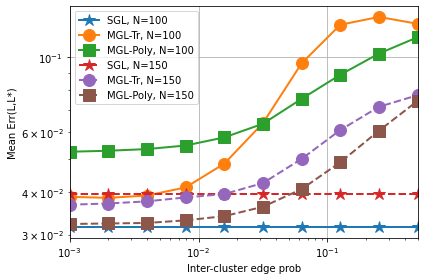

In [ ]:
model_list = [{'name': '{}, N={}'.format(model['name'], N1), 'fmt': model['fmt']} for model in models1] +\
             [{'name': '{}, N={}'.format(model['name'], N2), 'fmt': model['fmt']} for model in models2]

err_L1, err_lamb1 = est_errs(Ls1, lamds1, Ls_hat1, lamds_hat1)
err_L2, err_lamb2 = est_errs(Ls2, lamds2, Ls_hat2, lamds_hat2)

mean_err_L1 = np.median(err_L1, 2)
mean_err_L2 = np.median(err_L2, 2)
err_L_list = np.concatenate((mean_err_L1,mean_err_L2), axis=0)

plot_err(QQ0, model_list, err_L_list, 'Mean Err(L,L*)', logy=True)

In [ ]:
# Save data as csv
# model_list = [{'name': '{}{}'.format(model['name'], N1), 'fmt': model['fmt']} for model in models1] +\
#              [{'name': '{}{}'.format(model['name'], N2), 'fmt': model['fmt']} for model in models2]

# fname = PATH + 'ref_graph_errs.csv'
# utils.error_to_csv(fname, model_list, QQ0, err_L_list)

SAVED as: ./results/ref_graph_errs/ref_graph_errs.csv


In [ ]:
# # Save data
# models1_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models1]
# models2_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': \
#                model['regs'] if 'regs' in model.keys() else {}} 
#                for model in models2]
# data = {
#     'Ls1': Ls1,
#     'lamds1': lamds1,
#     'Ls_hat1': Ls_hat1,
#     'lamds_hat1': lamds_hat1,
#     'cs_err1': cs_err1,
#     'models1': models1_aux,
#     'Ls2': Ls2,
#     'lamds2': lamds2,
#     'Ls_hat2': Ls_hat2,
#     'lamds_hat2': lamds_hat2,
#     'cs_err2': cs_err2,
#     'models2': models2_aux,
#     'QQ0': QQ0,
#     'iters' : iters,
    
#     'M': M,
# }
# file = 'ref-errs_{}graphs_{}iters_{}M'.format(n_graphs, iters, M)
# np.save('results/ref_graph_errs/' + file, data)

In [ ]:
# Load NEW data
# %matplotlib qt
# file = PATH + 'ref-errs_100graphs_200iters_1000M.npy'
# data = np.load(file, allow_pickle=True).item()

# models1 = data['models1']
# Ls1 = data['Ls1']
# lamds1 = data['lamds1']
# Ls_hat1 = data['Ls_hat1']
# lamds_hat1 = data['lamds_hat1']
# cs_err1 = data['cs_err1']
# models2 = data['models2']
# Ls2 = data['Ls2']
# lamds2 = data['lamds2']
# Ls_hat2 = data['Ls_hat2']
# lamds_hat2 = data['lamds_hat2']
# cs_err2 = data['cs_err2']
# QQ0 = data['QQ0']
# iters = data['iters']
# # models2 = data['models2']
# M = data['M']  